# Census Set

In [1]:
import pandas as pd
import numpy as np
import pickle
from utils import *
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import StratifiedKFold, cross_validate
from slice_finder import SliceFinder
import warnings
warnings.filterwarnings('ignore')


## Viewing regions identified for the Census set

In [2]:
with open('./Slices/Census.p', 'rb') as file:
    data = pickle.load(file)
    
    data = sorted(data, key=lambda d: d.size, reverse=True)
    for d in data:
        print(f'Description of the region:  {d.filters}')
        print(f'Region instances: {d.data_idx}')
        print(f'Region size:    {d.size}')
        print(f'Efect size: {d.effect_size}')
        print(f'Log Loss:    {d.metric}')
        print('\n')

Description of the region:  {'Martial Status': [[2]]}
Region instances: Index([    1,     3,     4,     5,     7,     9,    10,    11,    15,    18,
       ...
       32533, 32545, 32547, 32550, 32551, 32552, 32554, 32556, 32557, 32560],
      dtype='int64', length=14065)
Region size:    14065
Efect size: 0.5798723269928144
Log Loss:    0.5539951272511505


Description of the region:  {'Relationship': [[0]]}
Region instances: Index([    1,     3,     7,     9,    10,    11,    15,    18,    20,    22,
       ...
       32522, 32526, 32532, 32533, 32547, 32550, 32551, 32552, 32554, 32557],
      dtype='int64', length=12463)
Region size:    12463
Efect size: 0.501722802648641
Log Loss:    0.540535012920946


Description of the region:  {'Relationship': [[5]]}
Region instances: Index([    4,     5,    37,    50,    52,    67,    82,   113,   125,   137,
       ...
       32421, 32425, 32428, 32479, 32485, 32513, 32528, 32545, 32556, 32560],
      dtype='int64', length=1406)
Region size:  

# Evaluating performance

In [4]:
adult_data_train = pd.read_csv(
    "data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "EducationNum", "MartialStatus",
        "Occupation", "Relationship", "Race", "Sex", "CapitalGain", "CapitalLoss",
        "Hoursperweek", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

# drop nan values
adult_data_train = adult_data_train.dropna()

# Encode categorical features
encoders = {}
for column in adult_data_train.columns:
    if adult_data_train.dtypes[column] == np.object_:
        le = LabelEncoder()
        adult_data_train[column] = le.fit_transform(adult_data_train[column])
        encoders[column] = le
        print(column, le.classes_, le.transform(le.classes_))

X_train, y_train = adult_data_train[adult_data_train.columns.difference(["Target"])], adult_data_train["Target"]

Workclass ['Federal-gov' 'Local-gov' 'Private' 'Self-emp-inc' 'Self-emp-not-inc'
 'State-gov' 'Without-pay'] [0 1 2 3 4 5 6]
Education ['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
MartialStatus ['Divorced' 'Married-AF-spouse' 'Married-civ-spouse'
 'Married-spouse-absent' 'Never-married' 'Separated' 'Widowed'] [0 1 2 3 4 5 6]
Occupation ['Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv' 'Prof-specialty' 'Protective-serv' 'Sales'
 'Tech-support' 'Transport-moving'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Relationship ['Husband' 'Not-in-family' 'Other-relative' 'Own-child' 'Unmarried' 'Wife'] [0 1 2 3 4 5]
Race ['Amer-Indian-Eskimo' 'Asian-Pac-Islander' 'Black' 'Other' 'White'] [0 1 2 3 4]
Sex ['Female' 'Ma

In [5]:
adult_data_train.groupby('Target').describe()

Age                                                    Workclass  \
          count      mean        std   min   25%   50%   75%   max     count   
Target                                                                         
0       22654.0  36.60806  13.464631  17.0  26.0  34.0  45.0  90.0   22654.0   
1        7508.0  43.95911  10.269633  19.0  36.0  43.0  51.0  90.0    7508.0   

                  ... Hoursperweek        Country                            \
            mean  ...          75%   max    count       mean       std  min   
Target            ...                                                         
0       2.189415  ...         40.0  99.0  22654.0  36.300786  6.188487  0.0   
1       2.229222  ...         50.0  99.0   7508.0  36.629329  5.840897  0.0   

                                
         25%   50%   75%   max  
Target                          
0       38.0  38.0  38.0  40.0  
1       38.0  38.0  38.0  40.0  

[2 rows x 112 columns]

In [ ]:

adult_data_test = pd.read_csv(
    "data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "EducationNum", "MartialStatus",
        "Occupation", "Relationship", "Race", "Sex", "CapitalGain", "CapitalLoss",
        "Hoursperweek", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

# drop nan values
adult_data_test = adult_data_test.dropna()

# Encode categorical features
encoders = {}
for column in adult_data_test.columns:
    if adult_data_test.dtypes[column] == np.object_:
        le = LabelEncoder()
        adult_data_test[column] = le.fit_transform(adult_data_test[column])
        encoders[column] = le
        print(column, le.classes_, le.transform(le.classes_))

X_val, y_val = adult_data_test[adult_data_test.columns.difference(["Target"])], adult_data_test["Target"]

Workclass ['Federal-gov' 'Local-gov' 'Private' 'Self-emp-inc' 'Self-emp-not-inc'
 'State-gov' 'Without-pay'] [0 1 2 3 4 5 6]
Education ['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
MartialStatus ['Divorced' 'Married-AF-spouse' 'Married-civ-spouse'
 'Married-spouse-absent' 'Never-married' 'Separated' 'Widowed'] [0 1 2 3 4 5 6]
Occupation ['Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv' 'Prof-specialty' 'Protective-serv' 'Sales'
 'Tech-support' 'Transport-moving'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Relationship ['Husband' 'Not-in-family' 'Other-relative' 'Own-child' 'Unmarried' 'Wife'] [0 1 2 3 4 5]
Race ['Amer-Indian-Eskimo' 'Asian-Pac-Islander' 'Black' 'Other' 'White'] [0 1 2 3 4]
Sex ['Female' 'Ma

In [4]:
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

start_time_model = time.time()
rf_optimized = model_train(X_train, y_train)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_train, y_train, cv=skf, scoring=scoring)

rf_optimized.fit(X_train, y_train)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

print("Size of dataset:", len(X_train))
print("Time to train the model:", execution_time_model, "s")

print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))


Size of dataset: 30162
Time to train the model: 352.6971046924591 s

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.00)
Recall: 0.61 (+/- 0.01)
F1 Score: 0.69 (+/- 0.01)
Log-loss: 0.31 (+/- 0.01)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.23

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     22654
           1       0.86      0.70      0.77      7508

    accuracy                           0.90     30162
   macro avg       0.88      0.83      0.85     30162
weighted avg       0.89      0.90      0.89     30162



## Applying SMOTE to the entire set

In [5]:
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

smote = SMOTE(sampling_strategy='auto', random_state=42)

y_slice = y_train
X_slice = X_train

X_slice_smote, y_slice_smote = smote.fit_resample(X_slice, y_slice)
region_SMOTE = (pd.concat([pd.DataFrame(X_slice_smote, columns=X_slice.columns), pd.Series(y_slice_smote, name='Target')], axis=1))

y_SMOTE_data = region_SMOTE['Target']
X_SMOTE_data = region_SMOTE.drop(columns='Target')

start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

rf_optimized.fit(X_SMOTE_data, y_SMOTE_data)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

print("Size of new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "s")

print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of new dataset: 45308
Time to train the model: 617.3784065246582 s

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.89 (+/- 0.00)
Recall: 0.90 (+/- 0.00)
F1 Score: 0.89 (+/- 0.00)
Log-loss: 0.25 (+/- 0.00)

Results on the validation set:
Accuracy: 0.94
Log-loss: 0.16

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     22654
           1       0.85      0.91      0.88      7508

    accuracy                           0.94     30162
   macro avg       0.91      0.93      0.92     30162
weighted avg       0.94      0.94      0.94     30162



### Data augmentation guided by problem regions

In [7]:
adult_data_train.groupby('Target').describe()

Age                                                    Workclass  \
          count      mean        std   min   25%   50%   75%   max     count   
Target                                                                         
0       22654.0  36.60806  13.464631  17.0  26.0  34.0  45.0  90.0   22654.0   
1        7508.0  43.95911  10.269633  19.0  36.0  43.0  51.0  90.0    7508.0   

                  ... Hoursperweek        Country                            \
            mean  ...          75%   max    count       mean       std  min   
Target            ...                                                         
0       2.189415  ...         40.0  99.0  22654.0  36.300786  6.188487  0.0   
1       2.229222  ...         50.0  99.0   7508.0  36.629329  5.840897  0.0   

                                
         25%   50%   75%   max  
Target                          
0       38.0  38.0  38.0  40.0  
1       38.0  38.0  38.0  40.0  

[2 rows x 112 columns]

1109

In [6]:
region = adult_data_train.query('MartialStatus==2')
region.groupby('Target').describe()

Age                                                     Workclass  \
         count       mean        std   min   25%   50%   75%   max     count   
Target                                                                         
0       7666.0  41.636968  12.653064  17.0  32.0  40.0  50.0  90.0    7666.0   
1       6399.0  44.127989  10.112189  21.0  37.0  44.0  51.0  90.0    6399.0   

                  ... Hoursperweek       Country                            \
            mean  ...          75%   max   count       mean       std  min   
Target            ...                                                        
0       2.316332  ...         45.0  99.0  7666.0  36.148448  6.315194  0.0   
1       2.235506  ...         50.0  99.0  6399.0  36.614784  5.906077  0.0   

                                
         25%   50%   75%   max  
Target                          
0       38.0  38.0  38.0  40.0  
1       38.0  38.0  38.0  40.0  

[2 rows x 112 columns]

In [8]:
adult_data_train.groupby('MartialStatus').describe()

Age                                                       \
                 count       mean        std   min    25%   50%   75%   max   
MartialStatus                                                                 
0               4214.0  42.874703  10.156126  18.0  35.00  42.0  49.0  90.0   
1                 21.0  30.666667   7.309811  19.0  26.00  30.0  35.0  47.0   
2              14065.0  42.770281  11.632420  17.0  34.00  42.0  51.0  90.0   
3                370.0  40.302703  12.092921  18.0  30.25  40.0  48.0  80.0   
4               9726.0  28.461444   9.953377  17.0  21.00  26.0  33.0  90.0   
5                939.0  39.397231  10.532154  19.0  32.00  39.0  46.0  90.0   
6                827.0  57.750907  11.869278  22.0  50.50  58.0  66.0  90.0   

              Workclass            ... Country         Target            \
                  count      mean  ...     75%   max    count      mean   
MartialStatus                      ...                                    
0                4214.0  2.142383  ...    38.0  40.0   4214.0  0.107262   
1                  21.0  2.047619  ...    38.0  38.0     21.0  0.476190   
2               14065.0  2.279559  ...    38.0  40.0  14065.0  0.454959   
3                 370.0  2.210811  ...    38.0  39.0    370.0  0.083784   
4                9726.0  2.119885  ...    38.0  40.0   9726.0  0.048324   
5                 939.0  2.145900  ...    38.0  38.0    939.0  0.070288   
6                 827.0  2.118501  ...    38.0  38.0    827.0  0.096735   

                                                  
                    std  min  25%  50%  75%  max  
MartialStatus                                     
0              0.309482  0.0  0.0  0.0  0.0  1.0  
1              0.511766  0.0  0.0  0.0  1.0  1.0  
2              0.497985  0.0  0.0  0.0  1.0  1.0  
3              0.277438  0.0  0.0  0.0  0.0  1.0  
4              0.214461  0.0  0.0  0.0  0.0  1.0  
5              0.255767  0.0  0.0  0.0  0.0  1.0  
6              0.295776  0.0  0.0  0.0  0.0  1.0  

[7 rows x 112 columns]

In [10]:
region = adult_data_train.query('MartialStatus==0')
region.groupby('Target').describe()

Age                                                     Workclass  \
         count       mean        std   min   25%   50%   75%   max     count   
Target                                                                         
0       3762.0  42.566986  10.302363  18.0  35.0  42.0  49.0  90.0    3762.0   
1        452.0  45.435841   8.429851  24.0  40.0  45.0  51.0  65.0     452.0   

                  ... Hoursperweek       Country                            \
            mean  ...          75%   max   count       mean       std  min   
Target            ...                                                        
0       2.134503  ...         42.0  99.0  3762.0  36.906699  5.323820  1.0   
1       2.207965  ...         50.0  99.0   452.0  37.035398  4.716211  4.0   

                                
         25%   50%   75%   max  
Target                          
0       38.0  38.0  38.0  40.0  
1       38.0  38.0  38.0  38.0  

[2 rows x 112 columns]

In [11]:
region = adult_data_train.query('MartialStatus==1')
region.groupby('Target').describe()

Age                                                     Workclass  \
       count       mean       std   min   25%   50%    75%   max     count   
Target                                                                       
0       11.0  30.090909  8.104993  19.0  26.0  30.0  33.50  47.0      11.0   
1       10.0  31.300000  6.700746  22.0  27.5  29.5  34.75  43.0      10.0   

                  ... Hoursperweek       Country                               \
            mean  ...          75%   max   count  mean  std   min   25%   50%   
Target            ...                                                           
0       2.272727  ...         57.5  90.0    11.0  38.0  0.0  38.0  38.0  38.0   
1       1.800000  ...         43.5  50.0    10.0  38.0  0.0  38.0  38.0  38.0   

                    
         75%   max  
Target              
0       38.0  38.0  
1       38.0  38.0  

[2 rows x 112 columns]

In [12]:
region = adult_data_train.query('MartialStatus==3')
region.groupby('Target').describe()

Age                                                     Workclass  \
        count       mean        std   min   25%   50%   75%   max     count   
Target                                                                        
0       339.0  39.631268  11.966535  18.0  30.0  39.0  47.0  80.0     339.0   
1        31.0  47.645161  11.161088  28.0  41.5  48.0  52.0  77.0      31.0   

                  ... Hoursperweek       Country                             \
            mean  ...          75%   max   count       mean        std  min   
Target            ...                                                         
0       2.179941  ...         40.0  99.0   339.0  30.637168  11.257131  1.0   
1       2.548387  ...         52.5  80.0    31.0  34.290323   8.695568  0.0   

                                
         25%   50%   75%   max  
Target                          
0       25.0  38.0  38.0  39.0  
1       38.0  38.0  38.0  38.0  

[2 rows x 112 columns]

In [9]:
region = adult_data_train.query('MartialStatus==4')
region.groupby('Target').describe()

Age                                                      Workclass  \
         count       mean        std   min    25%   50%   75%   max     count   
Target                                                                          
0       9256.0  27.974395   9.695621  17.0  21.00  25.0  32.0  90.0    9256.0   
1        470.0  38.053191  10.116556  19.0  30.25  36.0  44.0  90.0     470.0   

                  ... Hoursperweek       Country                            \
            mean  ...          75%   max   count       mean       std  min   
Target            ...                                                        
0       2.116141  ...         40.0  99.0  9256.0  36.428047  5.959290  0.0   
1       2.193617  ...         50.0  90.0   470.0  36.795745  5.317307  1.0   

                                
         25%   50%   75%   max  
Target                          
0       38.0  38.0  38.0  40.0  
1       38.0  38.0  38.0  39.0  

[2 rows x 112 columns]

In [13]:
region = adult_data_train.query('MartialStatus==5')
region.groupby('Target').describe()

Age                                                      Workclass  \
        count       mean        std   min    25%   50%   75%   max     count   
Target                                                                         
0       873.0  39.174112  10.540090  19.0  31.00  38.0  46.0  90.0     873.0   
1        66.0  42.348485  10.043739  23.0  34.25  42.0  48.5  64.0      66.0   

                 ... Hoursperweek       Country                            \
           mean  ...          75%   max   count       mean       std  min   
Target           ...                                                        
0       2.15693  ...         40.0  99.0   873.0  35.714777  7.065550  1.0   
1       2.00000  ...         50.0  80.0    66.0  36.378788  6.085962  3.0   

                                
         25%   50%   75%   max  
Target                          
0       38.0  38.0  38.0  38.0  
1       38.0  38.0  38.0  38.0  

[2 rows x 112 columns]

In [14]:
region = adult_data_train.query('MartialStatus==6')
region.groupby('Target').describe()

Age                                                     Workclass  \
        count      mean        std   min    25%   50%   75%   max     count   
Target                                                                        
0       747.0  57.69344  11.907643  22.0  50.50  58.0  65.5  90.0     747.0   
1        80.0  58.28750  11.564014  29.0  50.75  58.0  67.0  81.0      80.0   

                 ... Hoursperweek       Country                            \
           mean  ...          75%   max   count       mean       std  min   
Target           ...                                                        
0       2.11245  ...         40.0  99.0   747.0  36.465863  6.047830  1.0   
1       2.17500  ...         50.0  80.0    80.0  35.462500  7.612355  7.0   

                                
         25%   50%   75%   max  
Target                          
0       38.0  38.0  38.0  38.0  
1       38.0  38.0  38.0  38.0  

[2 rows x 112 columns]

In [ ]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'MartialStatus==2'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data) 

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the new dataset:", len(X_SMOTE_data))
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 649.7774453163147 seconds
Size of the new dataset: 31429

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.85 (+/- 0.01)
Recall: 0.67 (+/- 0.01)
F1 Score: 0.72 (+/- 0.01)
Log-loss: 0.32 (+/- 0.01)

Results on the validation set:
Accuracy: 0.88
Log-loss: 0.26

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     22654
           1       0.81      0.69      0.75      7508

    accuracy                           0.88     30162
   macro avg       0.86      0.82      0.84     30162
weighted avg       0.88      0.88      0.88     30162



In [9]:
region = adult_data_train.query('Relationship==0')
region.groupby('Target').describe()

Age                                                     Workclass  \
         count       mean        std   min   25%   50%   75%   max     count   
Target                                                                         
0       6784.0  42.131191  12.643627  17.0  32.0  40.0  51.0  90.0    6784.0   
1       5679.0  44.561719  10.074241  22.0  37.0  44.0  51.0  90.0    5679.0   

                  ... Hoursperweek       Country                            \
            mean  ...          75%   max   count       mean       std  min   
Target            ...                                                        
0       2.330041  ...         48.0  99.0  6784.0  36.283903  6.090564  0.0   
1       2.244409  ...         50.0  99.0  5679.0  36.684804  5.727642  0.0   

                                
         25%   50%   75%   max  
Target                          
0       38.0  38.0  38.0  40.0  
1       38.0  38.0  38.0  40.0  

[2 rows x 112 columns]

In [9]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'Relationship==0'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data) 

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the new dataset:", len(X_SMOTE_data))
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 631.5649538040161 seconds
Size of the new dataset: 31267

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.01)
Recall: 0.68 (+/- 0.01)
F1 Score: 0.73 (+/- 0.01)
Log-loss: 0.30 (+/- 0.01)

Results on the validation set:
Accuracy: 0.91
Log-loss: 0.21

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     22654
           1       0.87      0.77      0.82      7508

    accuracy                           0.91     30162
   macro avg       0.90      0.87      0.88     30162
weighted avg       0.91      0.91      0.91     30162



In [12]:
region = adult_data_train.query('CapitalGain==0 and Relationship==5')
region.groupby('Target').describe()

Age                                                     Workclass  \
        count       mean        std   min   25%   50%   75%   max     count   
Target                                                                        
0       666.0  38.833333  11.622670  18.0  29.0  38.0  47.0  77.0     666.0   
1       564.0  40.432624   9.661816  21.0  33.0  40.0  47.0  90.0     564.0   

                  ... Hoursperweek       Country                            \
            mean  ...          75%   max   count       mean       std  min   
Target            ...                                                        
0       2.213213  ...         40.0  99.0   666.0  35.848348  6.708729  1.0   
1       2.154255  ...         40.0  80.0   564.0  35.987589  7.293019  1.0   

                                
         25%   50%   75%   max  
Target                          
0       38.0  38.0  38.0  39.0  
1       38.0  38.0  38.0  40.0  

[2 rows x 112 columns]

In [10]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'CapitalGain==0 and Relationship==5'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data) 

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the new dataset:", len(X_SMOTE_data))
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 472.51897382736206 seconds
Size of the new dataset: 30264

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.01)
Recall: 0.64 (+/- 0.01)
F1 Score: 0.70 (+/- 0.01)
Log-loss: 0.31 (+/- 0.01)

Results on the validation set:
Accuracy: 0.93
Log-loss: 0.18

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     22654
           1       0.90      0.80      0.85      7508

    accuracy                           0.93     30162
   macro avg       0.92      0.89      0.90     30162
weighted avg       0.93      0.93      0.93     30162



In [14]:
region = adult_data_train.query('Education==14 and CapitalGain==0')
region.groupby('Target').describe()

Age                                                       Workclass  \
        count       mean        std   min    25%   50%    75%   max     count   
Target                                                                          
0       128.0  42.945312  15.263207  25.0  29.75  40.0  53.25  88.0     128.0   
1       275.0  44.040000   9.629365  26.0  37.00  43.0  50.00  80.0     275.0   

                  ... Hoursperweek       Country                            \
            mean  ...          75%   max   count       mean       std  min   
Target            ...                                                        
0       2.515625  ...         50.0  99.0   128.0  35.585938  7.725128  1.0   
1       2.654545  ...         55.0  99.0   275.0  36.021818  6.602330  3.0   

                                
         25%   50%   75%   max  
Target                          
0       38.0  38.0  38.0  38.0  
1       38.0  38.0  38.0  38.0  

[2 rows x 112 columns]

In [11]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'Education==14 and CapitalGain==0'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data) 

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the new dataset:", len(X_SMOTE_data))
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 603.9411723613739 seconds
Size of the new dataset: 30309

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.00)
Recall: 0.61 (+/- 0.01)
F1 Score: 0.69 (+/- 0.01)
Log-loss: 0.30 (+/- 0.01)

Results on the validation set:
Accuracy: 0.89
Log-loss: 0.24

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     22654
           1       0.85      0.68      0.76      7508

    accuracy                           0.89     30162
   macro avg       0.88      0.82      0.84     30162
weighted avg       0.89      0.89      0.89     30162



In [16]:
region = adult_data_train.query('CapitalGain==0 and EducationNum==15')
region.groupby('Target').describe()

Age                                                       Workclass  \
        count       mean        std   min    25%   50%    75%   max     count   
Target                                                                          
0       128.0  42.945312  15.263207  25.0  29.75  40.0  53.25  88.0     128.0   
1       275.0  44.040000   9.629365  26.0  37.00  43.0  50.00  80.0     275.0   

                  ... Hoursperweek       Country                            \
            mean  ...          75%   max   count       mean       std  min   
Target            ...                                                        
0       2.515625  ...         50.0  99.0   128.0  35.585938  7.725128  1.0   
1       2.654545  ...         55.0  99.0   275.0  36.021818  6.602330  3.0   

                                
         25%   50%   75%   max  
Target                          
0       38.0  38.0  38.0  38.0  
1       38.0  38.0  38.0  38.0  

[2 rows x 112 columns]

In [12]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'CapitalGain==0 and EducationNum==15'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data) 

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the new dataset:", len(X_SMOTE_data))
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 637.5830273628235 seconds
Size of the new dataset: 30309

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.00)
Recall: 0.61 (+/- 0.01)
F1 Score: 0.69 (+/- 0.01)
Log-loss: 0.30 (+/- 0.01)

Results on the validation set:
Accuracy: 0.89
Log-loss: 0.24

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     22654
           1       0.85      0.68      0.76      7508

    accuracy                           0.89     30162
   macro avg       0.88      0.82      0.84     30162
weighted avg       0.89      0.89      0.89     30162



### removal of the problematic region

In [6]:
def import_census():
    adult_data_train = pd.read_csv(
    "data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "EducationNum", "MartialStatus",
        "Occupation", "Relationship", "Race", "Sex", "CapitalGain", "CapitalLoss",
        "Hoursperweek", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

    # drop nan values
    adult_data_train = adult_data_train.dropna()

    # Encode categorical features
    encoders = {}
    for column in adult_data_train.columns:
        if adult_data_train.dtypes[column] == np.object_:
            le = LabelEncoder()
            adult_data_train[column] = le.fit_transform(adult_data_train[column])
            encoders[column] = le
            #print(column, le.classes_, le.transform(le.classes_))

    X_train, y_train = adult_data_train[adult_data_train.columns.difference(["Target"])], adult_data_train["Target"]
    
    return adult_data_train, X_train, y_train

In [ ]:
adult_data_train_, X_train, y_train = import_census()

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region for removal
region = 'CapitalGain==0 and Relationship==5'

# Identify and remove samples from the specified region
region_remove_idx = adult_data_train_.query(region).index
adult_data_train_.drop(region_remove_idx, errors='ignore', inplace=True)

# Ensure that the training set columns remain consistent
X_slice = adult_data_train_.drop(columns=['Target'])
y_slice = adult_data_train_['Target']

# Reindex the validation set to ensure consistency with the training set
X_val = X_val.reindex(columns=X_slice.columns, fill_value=0)

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_slice, y_slice)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_slice, y_slice, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_slice, y_slice)

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the dataset after removal:", len(X_slice))
print(f"Number of samples removed: {len(region_remove_idx)}")
print(f"Original set proportion: {len(region_remove_idx) / (len(X_train)):.2%}")

# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 253.06468629837036 seconds
Size of the dataset after removal: 28932
Number of samples removed: 1230
Original set proportion: 4.08%

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.87 (+/- 0.00)
Recall: 0.61 (+/- 0.01)
F1 Score: 0.69 (+/- 0.01)
Log-loss: 0.29 (+/- 0.00)

Results on the validation set:
Accuracy: 0.88
Log-loss: 0.26

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     22654
           1       0.84      0.62      0.71      7508

    accuracy                           0.88     30162
   macro avg       0.86      0.79      0.82     30162
weighted avg       0.87      0.88      0.87     30162



!!!!

In [14]:
adult_data_train_, X_train, y_train = import_census()

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region for removal
region = 'MartialStatus==2'

# Identify and remove samples from the specified region
region_remove_idx = adult_data_train_.query(region).index
adult_data_train_.drop(region_remove_idx, errors='ignore', inplace=True)

# Ensure that the training set columns remain consistent
X_slice = adult_data_train_.drop(columns=['Target'])
y_slice = adult_data_train_['Target']

# Reindex the validation set to ensure consistency with the training set
X_val = X_val.reindex(columns=X_slice.columns, fill_value=0)

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_slice, y_slice)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_slice, y_slice, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_slice, y_slice)

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the dataset after removal:", len(X_slice))
print(f"Number of samples removed: {len(region_remove_idx)}")
print(f"Original set proportion: {len(region_remove_idx) / (len(X_train)):.2%}")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 177.32832503318787 seconds
Size of the dataset after removal: 16097
Number of samples removed: 14065
Original set proportion: 46.63%

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.95 (+/- 0.00)
Recall: 0.35 (+/- 0.02)
F1 Score: 0.50 (+/- 0.02)
Log-loss: 0.15 (+/- 0.01)

Results on the validation set:
Accuracy: 0.81
Log-loss: 0.42

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     22654
           1       0.96      0.24      0.39      7508

    accuracy                           0.81     30162
   macro avg       0.88      0.62      0.64     30162
weighted avg       0.84      0.81      0.76     30162



In [10]:
adult_data_train_, X_train, y_train = import_census()

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region for removal
region = 'CapitalGain==0 and EducationNum==15'

# Identify and remove samples from the specified region
region_remove_idx = adult_data_train_.query(region).index
adult_data_train_.drop(region_remove_idx, errors='ignore', inplace=True)

# Ensure that the training set columns remain consistent
X_slice = adult_data_train_.drop(columns=['Target'])
y_slice = adult_data_train_['Target']

# Reindex the validation set to ensure consistency with the training set
X_val = X_val.reindex(columns=X_slice.columns, fill_value=0)

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_slice, y_slice)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_slice, y_slice, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_slice, y_slice)

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the dataset after removal:", len(X_slice))
print(f"Number of samples removed: {len(region_remove_idx)}")
print(f"Original set proportion: {len(region_remove_idx) / (len(X_train)):.2%}")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 412.4635100364685 seconds
Size of the dataset after removal: 29759
Number of samples removed: 403
Original set proportion: 1.34%

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.00)
Recall: 0.61 (+/- 0.01)
F1 Score: 0.68 (+/- 0.01)
Log-loss: 0.30 (+/- 0.01)

Results on the validation set:
Accuracy: 0.92
Log-loss: 0.19

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     22654
           1       0.89      0.76      0.82      7508

    accuracy                           0.92     30162
   macro avg       0.91      0.87      0.89     30162
weighted avg       0.92      0.92      0.92     30162



In [11]:
adult_data_train_, X_train, y_train = import_census()

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region for removal
region = 'Country==38 and Relationship==5'

# Identify and remove samples from the specified region
region_remove_idx = adult_data_train_.query(region).index
adult_data_train_.drop(region_remove_idx, errors='ignore', inplace=True)

# Ensure that the training set columns remain consistent
X_slice = adult_data_train_.drop(columns=['Target'])
y_slice = adult_data_train_['Target']

# Reindex the validation set to ensure consistency with the training set
X_val = X_val.reindex(columns=X_slice.columns, fill_value=0)

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_slice, y_slice)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_slice, y_slice, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_slice, y_slice)

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the dataset after removal:", len(X_slice))
print(f"Number of samples removed: {len(region_remove_idx)}")
print(f"Original set proportion: {len(region_remove_idx) / (len(X_train)):.2%}")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 388.86439514160156 seconds
Size of the dataset after removal: 28911
Number of samples removed: 1251
Original set proportion: 4.15%

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.87 (+/- 0.01)
Recall: 0.61 (+/- 0.01)
F1 Score: 0.69 (+/- 0.01)
Log-loss: 0.29 (+/- 0.01)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.22

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.91      0.97      0.93     22654
           1       0.87      0.70      0.77      7508

    accuracy                           0.90     30162
   macro avg       0.89      0.83      0.85     30162
weighted avg       0.90      0.90      0.89     30162



In [20]:
adult_data_train_, X_train, y_train = import_census()

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region for removal
region = 'Relationship==5 and Race==4'

# Identify and remove samples from the specified region
region_remove_idx = adult_data_train_.query(region).index
adult_data_train_.drop(region_remove_idx, errors='ignore', inplace=True)

# Ensure that the training set columns remain consistent
X_slice = adult_data_train_.drop(columns=['Target'])
y_slice = adult_data_train_['Target']

# Reindex the validation set to ensure consistency with the training set
X_val = X_val.reindex(columns=X_slice.columns, fill_value=0)

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_slice, y_slice)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_slice, y_slice, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_slice, y_slice)

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the dataset after removal:", len(X_slice))
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 605.1188187599182 seconds
Size of the dataset after removal: 28973

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.87 (+/- 0.01)
Recall: 0.61 (+/- 0.02)
F1 Score: 0.69 (+/- 0.02)
Log-loss: 0.29 (+/- 0.01)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.22

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     22654
           1       0.89      0.70      0.78      7508

    accuracy                           0.90     30162
   macro avg       0.90      0.84      0.86     30162
weighted avg       0.90      0.90      0.90     30162



### random region removal

In [ ]:
adult_data_train_, X_train, y_train = import_census()

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Randomly remove a defined number of rows
remove_rows = adult_data_train_.sample(n=len(adult_data_train_.query('Country==38 and Relationship==5').index)).index
adult_data_train_.drop(remove_rows, inplace=True)

# Prepare training data after removal
y_slice = adult_data_train_['Target']
X_slice = adult_data_train_.drop(columns=['Target'])

# Ensure validation set columns are aligned with the training set
X_val = X_val.reindex(columns=X_slice.columns, fill_value=0)

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_slice, y_slice)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_slice, y_slice, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_slice, y_slice)

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the dataset after removal:", len(X_slice))
print(f"Number of samples removed: {len(remove_rows)}")
print(f"Original set proportion: {len(remove_rows) / (len(X_train)):.2%}")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

In [ ]:
adult_data_train_, X_train, y_train = import_census()

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Randomly remove a defined number of rows
remove_rows = adult_data_train_.sample(n=len(adult_data_train_.query('Country==38 and Relationship==5').index)).index
adult_data_train_.drop(remove_rows, inplace=True)

# Prepare training data after removal
y_slice = adult_data_train_['Target']
X_slice = adult_data_train_.drop(columns=['Target'])

# Ensure validation set columns are aligned with the training set
X_val = X_val.reindex(columns=X_slice.columns, fill_value=0)

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_slice, y_slice)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_slice, y_slice, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_slice, y_slice)

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the dataset after removal:", len(X_slice))
print(f"Number of samples removed: {len(remove_rows)}")
print(f"Original set proportion: {len(remove_rows) / (len(X_train)):.2%}")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 379.7975311279297 seconds
Size of the dataset after removal: 28911
Number of samples removed: 1251
Original set proportion: 4.15%

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.00)
Recall: 0.62 (+/- 0.01)
F1 Score: 0.69 (+/- 0.01)
Log-loss: 0.31 (+/- 0.00)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.24

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     22654
           1       0.86      0.70      0.77      7508

    accuracy                           0.90     30162
   macro avg       0.88      0.83      0.85     30162
weighted avg       0.89      0.90      0.89     30162



In [13]:
adult_data_train_, X_train, y_train = import_census()

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Randomly remove a defined number of rows
remove_rows = adult_data_train_.sample(n=len(adult_data_train_.query('CapitalGain==0 and EducationNum==15').index)).index
adult_data_train_.drop(remove_rows, inplace=True)

# Prepare training data after removal
y_slice = adult_data_train_['Target']
X_slice = adult_data_train_.drop(columns=['Target'])

# Ensure validation set columns are aligned with the training set
X_val = X_val.reindex(columns=X_slice.columns, fill_value=0)

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_slice, y_slice)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_slice, y_slice, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_slice, y_slice)

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the dataset after removal:", len(X_slice))
print(f"Number of samples removed: {len(remove_rows)}")
print(f"Original set proportion: {len(remove_rows) / (len(X_train)):.2%}")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 365.36197900772095 seconds
Size of the dataset after removal: 29759
Number of samples removed: 403
Original set proportion: 1.34%

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.00)
Recall: 0.61 (+/- 0.01)
F1 Score: 0.69 (+/- 0.01)
Log-loss: 0.30 (+/- 0.01)

Results on the validation set:
Accuracy: 0.91
Log-loss: 0.21

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     22654
           1       0.88      0.74      0.80      7508

    accuracy                           0.91     30162
   macro avg       0.90      0.85      0.87     30162
weighted avg       0.91      0.91      0.91     30162



In [23]:
adult_data_train_, X_train, y_train = import_census()

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Randomly remove a defined number of rows
remove_rows = adult_data_train_.sample(n=len(adult_data_train_.query('CapitalGain==0 and Relationship==5').index)).index
adult_data_train_.drop(remove_rows, inplace=True)

# Prepare training data after removal
y_slice = adult_data_train_['Target']
X_slice = adult_data_train_.drop(columns=['Target'])

# Ensure validation set columns are aligned with the training set
X_val = X_val.reindex(columns=X_slice.columns, fill_value=0)

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_slice, y_slice)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_slice, y_slice, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_slice, y_slice)

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the dataset after removal:", len(X_slice))
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 494.975501537323 seconds
Size of the dataset after removal: 28932

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.00)
Recall: 0.61 (+/- 0.02)
F1 Score: 0.69 (+/- 0.01)
Log-loss: 0.30 (+/- 0.01)

Results on the validation set:
Accuracy: 0.89
Log-loss: 0.24

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     22654
           1       0.85      0.69      0.76      7508

    accuracy                           0.89     30162
   macro avg       0.88      0.82      0.85     30162
weighted avg       0.89      0.89      0.89     30162



!!!

In [15]:
adult_data_train_, X_train, y_train = import_census()

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Randomly remove a defined number of rows
remove_rows = adult_data_train_.sample(n=len(adult_data_train_.query('MartialStatus==2').index)).index
adult_data_train_.drop(remove_rows, inplace=True)

# Prepare training data after removal
y_slice = adult_data_train_['Target']
X_slice = adult_data_train_.drop(columns=['Target'])

# Ensure validation set columns are aligned with the training set
X_val = X_val.reindex(columns=X_slice.columns, fill_value=0)

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_slice, y_slice)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_slice, y_slice, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_slice, y_slice)

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the dataset after removal:", len(X_slice))
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 193.45456171035767 seconds
Size of the dataset after removal: 16097

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.00)
Recall: 0.62 (+/- 0.02)
F1 Score: 0.68 (+/- 0.01)
Log-loss: 0.31 (+/- 0.01)

Results on the validation set:
Accuracy: 0.89
Log-loss: 0.27

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     22654
           1       0.83      0.68      0.75      7508

    accuracy                           0.89     30162
   macro avg       0.86      0.82      0.84     30162
weighted avg       0.88      0.89      0.88     30162



# Case Study

In [3]:
import pandas as pd
import numpy as np
import pickle
from utils import *
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import StratifiedKFold, cross_validate
from slice_finder import SliceFinder
import warnings
warnings.filterwarnings('ignore')

adult_data_train = pd.read_csv(
    "data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "EducationNum", "MartialStatus",
        "Occupation", "Relationship", "Race", "Sex", "CapitalGain", "CapitalLoss",
        "Hoursperweek", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

# drop nan values
adult_data_train = adult_data_train.dropna()

# Encode categorical features
encoders = {}
for column in adult_data_train.columns:
    if adult_data_train.dtypes[column] == np.object_:
        le = LabelEncoder()
        adult_data_train[column] = le.fit_transform(adult_data_train[column])
        encoders[column] = le
        print(column, le.classes_, le.transform(le.classes_))

X_train, y_train = adult_data_train[adult_data_train.columns.difference(["Target"])], adult_data_train["Target"]
adult_data_test = pd.read_csv(
    "data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "EducationNum", "MartialStatus",
        "Occupation", "Relationship", "Race", "Sex", "CapitalGain", "CapitalLoss",
        "Hoursperweek", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

# drop nan values
adult_data_test = adult_data_test.dropna()

# Encode categorical features
encoders = {}
for column in adult_data_test.columns:
    if adult_data_test.dtypes[column] == np.object_:
        le = LabelEncoder()
        adult_data_test[column] = le.fit_transform(adult_data_test[column])
        encoders[column] = le
        print(column, le.classes_, le.transform(le.classes_))

X_val, y_val = adult_data_test[adult_data_test.columns.difference(["Target"])], adult_data_test["Target"]

Workclass ['Federal-gov' 'Local-gov' 'Private' 'Self-emp-inc' 'Self-emp-not-inc'
 'State-gov' 'Without-pay'] [0 1 2 3 4 5 6]
Education ['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
MartialStatus ['Divorced' 'Married-AF-spouse' 'Married-civ-spouse'
 'Married-spouse-absent' 'Never-married' 'Separated' 'Widowed'] [0 1 2 3 4 5 6]
Occupation ['Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv' 'Prof-specialty' 'Protective-serv' 'Sales'
 'Tech-support' 'Transport-moving'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Relationship ['Husband' 'Not-in-family' 'Other-relative' 'Own-child' 'Unmarried' 'Wife'] [0 1 2 3 4 5]
Race ['Amer-Indian-Eskimo' 'Asian-Pac-Islander' 'Black' 'Other' 'White'] [0 1 2 3 4]
Sex ['Female' 'Ma

# Initial view of regions

In [3]:
with open('Slices/Census.p', 'rb') as file:
    data = pickle.load(file)
    
    name = []
    aux_1 = []
    aux_2 = []
    
    data = sorted(data, key=lambda d: d.size, reverse=True)
    for d in data:
        print ('\n=====================\nSlice description:')
        for k, v in list(d.filters.items()):
            values = ''
            if k in encoders:
                le = encoders[k]
                for v_ in v:
                    values += '%s '%(le.inverse_transform(v_)[0])
            else:
                for v_ in sorted(v, key=lambda x: x[0]):
                    if len(v_) > 1:
                        values += '%s ~ %s'%(v_[0], v_[1])
                    else:
                        values += '%s '%(v_[0])
            print ('%s:%s'%(k, values))
        #print(f'Description of the region:  {d.filters}')
        print(f'Region instances: {d.data_idx}')
        print(f'Region size:    {d.size}')
        print(f'Efect size: {d.effect_size}')
        print(f'Log Loss:    {d.metric}')
        print('\n')
        
        if d.size > 10:
            aux_1.append(d.size)
            aux_2.append(d.effect_size)


Slice description:
Martial Status:2 
Region instances: Index([    1,     3,     4,     5,     7,     9,    10,    11,    15,    18,
       ...
       32533, 32545, 32547, 32550, 32551, 32552, 32554, 32556, 32557, 32560],
      dtype='int64', length=14065)
Region size:    14065
Efect size: 0.5798723269928144
Log Loss:    0.5539951272511505



Slice description:
Relationship:Husband 
Region instances: Index([    1,     3,     7,     9,    10,    11,    15,    18,    20,    22,
       ...
       32522, 32526, 32532, 32533, 32547, 32550, 32551, 32552, 32554, 32557],
      dtype='int64', length=12463)
Region size:    12463
Efect size: 0.501722802648641
Log Loss:    0.540535012920946



Slice description:
Relationship:Wife 
Region instances: Index([    4,     5,    37,    50,    52,    67,    82,   113,   125,   137,
       ...
       32421, 32425, 32428, 32479, 32485, 32513, 32528, 32545, 32556, 32560],
      dtype='int64', length=1406)
Region size:    1406
Efect size: 0.5139878396082956
L

In [18]:
import json
from collections import Counter

# Função para converter tipos NumPy para tipos Python nativos
def convert_types(obj):
    if isinstance(obj, dict):
        return {k: convert_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_types(i) for i in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_types(i) for i in obj)
    elif hasattr(obj, 'item'):  # np.int64, np.float64 etc.
        return obj.item()
    else:
        return obj

dicionario = {}

for d in data:
    if d.size > 10:
        filters_clean = convert_types(d.filters)
        filters_str = json.dumps(filters_clean, sort_keys=True)
        dicionario[filters_str] = []
        for i in d.data_idx:
            dicionario[filters_str].append(i)

feature_cont = Counter()

for feature in dicionario.keys():
    key_dict = json.loads(feature)
    for feature in key_dict.keys():
        feature_cont[feature] += 1

print(feature_cont)

Counter({'Age': 85, 'Hours per week': 54, 'Education': 41, 'Education-Num': 41, 'Capital Loss': 35, 'Occupation': 34, 'Workclass': 24, 'fnlwgt': 17, 'Country': 16, 'Capital Gain': 10, 'Martial Status': 8, 'Sex': 8, 'Relationship': 6, 'Race': 2})


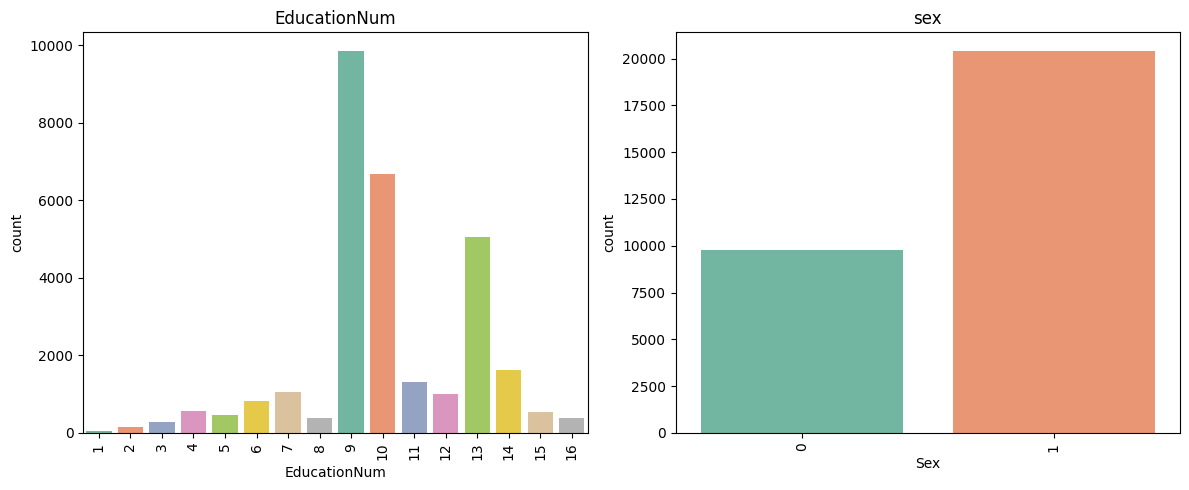

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='EducationNum', data=adult_data_train, palette='Set2')
plt.title('EducationNum')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x='Sex', data=adult_data_train, palette='Set2')
plt.title('sex')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

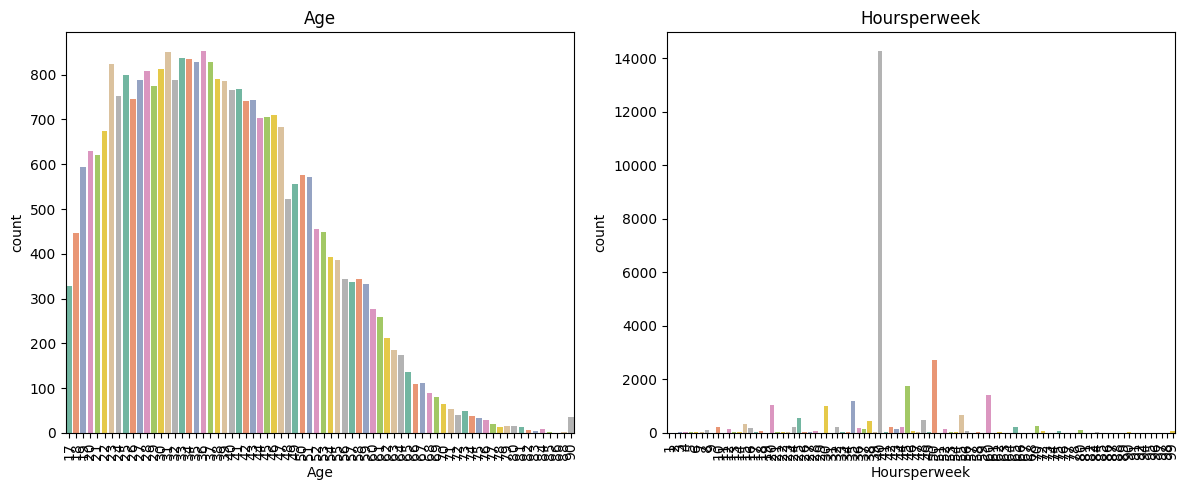

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Age', data=adult_data_train, palette='Set2')
plt.title('Age')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x='Hoursperweek', data=adult_data_train, palette='Set2')
plt.title('Hoursperweek')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

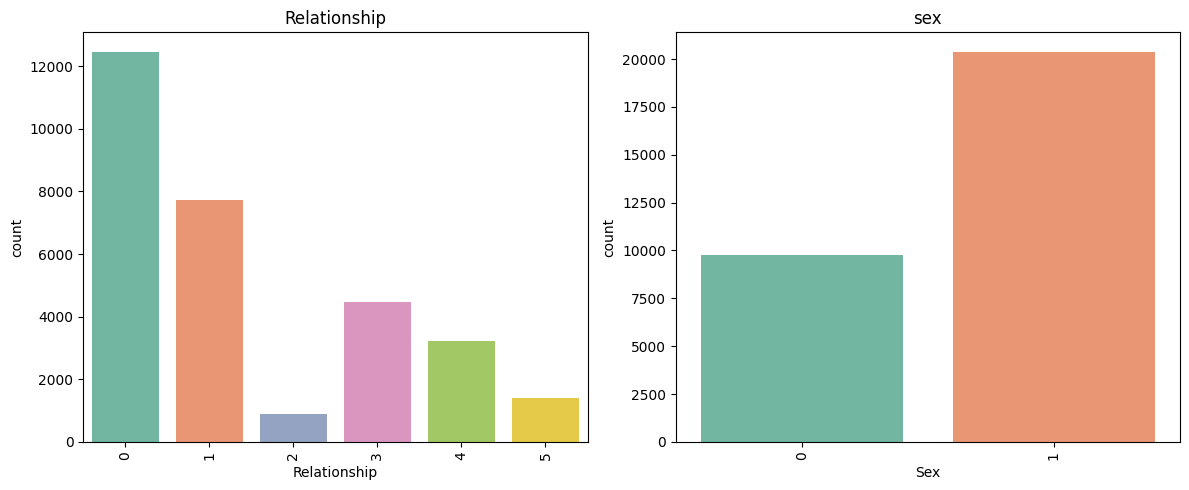

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Relationship', data=adult_data_train, palette='Set2')
plt.title('Relationship')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x='Sex', data=adult_data_train, palette='Set2')
plt.title('sex')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

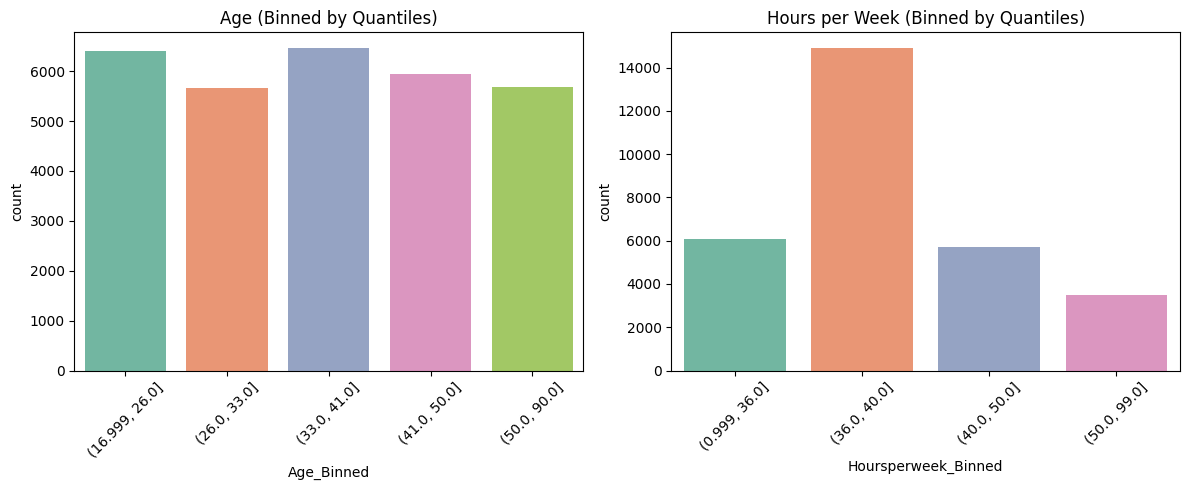

In [10]:
adult_data_train_copy = adult_data_train.copy()

adult_data_train_copy['Age_Binned'] = pd.qcut(adult_data_train_copy['Age'], q=5)
adult_data_train_copy['Hoursperweek_Binned'] = pd.qcut(adult_data_train_copy['Hoursperweek'], q=5, duplicates='drop')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Age_Binned', data=adult_data_train_copy, palette='Set2')
plt.title('Age (Binned by Quantiles)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(x='Hoursperweek_Binned', data=adult_data_train_copy, palette='Set2')
plt.title('Hours per Week (Binned by Quantiles)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

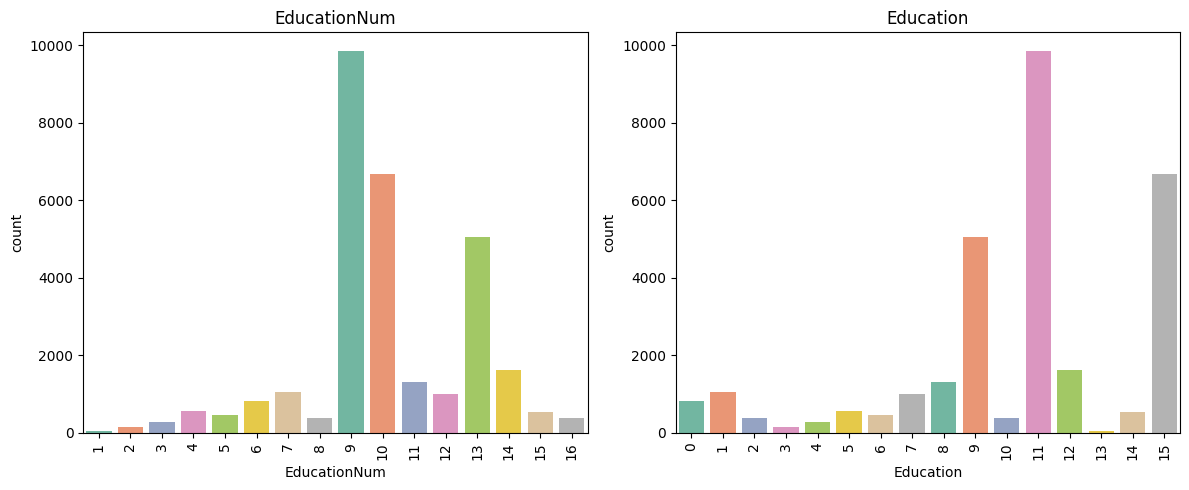

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='EducationNum', data=adult_data_train, palette='Set2')
plt.title('EducationNum')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x='Education', data=adult_data_train, palette='Set2')
plt.title('Education')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Education e EducationNum são features que descrevem a mesma coisa

In [32]:
# Cópia dos dados
adult_data_train_copy = adult_data_train.copy()
adult_data_test_copy = adult_data_test.copy()

adult_data_train_copy.drop(columns=["EducationNum"], inplace=True)
adult_data_test_copy.drop(columns=["EducationNum"], inplace=True)

# Calcula os quantis no treino
age_bins = pd.qcut(adult_data_train_copy['Age'], q=5, retbins=True, duplicates='drop')[1]
hours_bins = pd.qcut(adult_data_train_copy['Hoursperweek'], q=5, retbins=True, duplicates='drop')[1]

# Aplica os mesmos cortes em treino e teste
adult_data_train_copy['Age_Binned'] = pd.cut(adult_data_train_copy['Age'], bins=age_bins, include_lowest=True, labels=False)
adult_data_train_copy['Hoursperweek_Binned'] = pd.cut(adult_data_train_copy['Hoursperweek'], bins=hours_bins, include_lowest=True, labels=False)

adult_data_test_copy['Age_Binned'] = pd.cut(adult_data_test_copy['Age'], bins=age_bins, include_lowest=True, labels=False)
adult_data_test_copy['Hoursperweek_Binned'] = pd.cut(adult_data_test_copy['Hoursperweek'], bins=hours_bins, include_lowest=True, labels=False)

adult_data_train_copy.drop(columns=["Age"], inplace=True)
adult_data_test_copy.drop(columns=["Age"], inplace=True)

adult_data_train_copy.drop(columns=["Hoursperweek"], inplace=True)
adult_data_test_copy.drop(columns=["Hoursperweek"], inplace=True)

# Separação das features e alvo
X_train = adult_data_train_copy.drop(columns=["Target"])
y_train = adult_data_train_copy["Target"]

X_val = adult_data_test_copy.drop(columns=["Target"])
y_val = adult_data_test_copy["Target"]


In [33]:
adult_data_train_copy

,Workclass,fnlwgt,Education,MartialStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,Country,Target,Age_Binned,Hoursperweek_Binned
0,5,77516,9,4,0,1,4,1,2174,0,38,0,2,1
1,4,83311,9,2,3,0,4,1,0,0,38,0,3,0
2,2,215646,11,0,5,1,4,1,0,0,38,0,2,1
3,2,234721,1,2,5,0,2,1,0,0,38,0,4,1
4,2,338409,9,2,9,5,2,0,0,0,4,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,2,257302,7,2,12,5,4,0,0,0,38,0,1,1
32557,2,154374,11,2,6,0,4,1,0,0,38,1,2,1
32558,2,151910,11,6,0,4,4,0,0,0,38,0,4,1
32559,2,201490,11,4,0,3,4,1,0,0,38,0,0,0


In [34]:
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

start_time_model = time.time()
rf_optimized = model_train(X_train, y_train)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_train, y_train, cv=skf, scoring=scoring)

rf_optimized.fit(X_train, y_train)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

print("Size of dataset:", len(X_train))
print("Time to train the model:", execution_time_model, "s")

print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 30162
Time to train the model: 316.0738253593445 s

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.00)
Recall: 0.62 (+/- 0.01)
F1 Score: 0.69 (+/- 0.01)
Log-loss: 0.31 (+/- 0.01)

Results on the validation set:
Accuracy: 0.89
Log-loss: 0.25

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     22654
           1       0.85      0.69      0.76      7508

    accuracy                           0.89     30162
   macro avg       0.88      0.83      0.85     30162
weighted avg       0.89      0.89      0.89     30162



In [35]:
lr = RandomForestClassifier(max_depth=5, n_estimators=10)
lr.fit(X_train, y_train)

sf = SliceFinder(lr, (X_train, y_train))
metrics_all = sf.evaluate_model((X_train,y_train))
reference = (np.mean(metrics_all), np.std(metrics_all), len(metrics_all))

In [36]:
name = 'Census_revised.p'
recommendations = sf.find_slice(k=100, epsilon=0.4, degree=2, max_workers=4, name=name)

for s in recommendations:
    print ('\n=====================\nSlice description:')
    for k, v in list(s.filters.items()):
        values = ''
        if k in encoders:
            le = encoders[k]
            for v_ in v:
                values += '%s '%(le.inverse_transform(v_)[0])
        else:
            for v_ in sorted(v, key=lambda x: x[0]):
                if len(v_) > 1:
                    values += '%s ~ %s'%(v_[0], v_[1])
                else:
                    values += '%s '%(v_[0])
        print ('%s:%s'%(k, values))
    print ('---------------------\neffect_size: %s'%(s.effect_size))
    print ('---------------------\nmetric: %s'%(s.metric))
    print ('size: %s'%(s.size))

degree 1
crossing
effect size filtering
degree 2
crossing
effect size filtering
sorting

Slice description:
MartialStatus:Married-civ-spouse 
---------------------
effect_size: 0.6588306284003721
---------------------
metric: 0.58905101170662
size: 14065

Slice description:
Relationship:Husband 
---------------------
effect_size: 0.6019368454792579
---------------------
metric: 0.584910583571972
size: 12463

Slice description:
Relationship:Wife 
---------------------
effect_size: 0.4793378819710367
---------------------
metric: 0.6590116417660637
size: 1406

Slice description:
Education:Masters 
Occupation:Exec-managerial 
---------------------
effect_size: 0.4187029134433624
---------------------
metric: 0.6518812434373024
size: 491

Slice description:
Education:Prof-school 
CapitalLoss:0 
---------------------
effect_size: 0.4245767767679836
---------------------
metric: 0.6422600531840102
size: 481

Slice description:
Education:Prof-school 
Sex:Male 
---------------------
effect_siz

In [4]:
with open('Slices/Census_revised.p', 'rb') as file:
    data = pickle.load(file)
    
    name = []
    aux_1 = []
    aux_2 = []
    
    data = sorted(data, key=lambda d: d.size, reverse=True)
    for d in data:
        print ('\n=====================\nSlice description:')
        for k, v in list(d.filters.items()):
            values = ''
            if k in encoders:
                le = encoders[k]
                for v_ in v:
                    values += '%s '%(le.inverse_transform(v_)[0])
            else:
                for v_ in sorted(v, key=lambda x: x[0]):
                    if len(v_) > 1:
                        values += '%s ~ %s'%(v_[0], v_[1])
                    else:
                        values += '%s '%(v_[0])
            print ('%s:%s'%(k, values))
        #print(f'Description of the region:  {d.filters}')
        print(f'Region instances: {d.data_idx}')
        print(f'Region size:    {d.size}')
        print(f'Efect size: {d.effect_size}')
        print(f'Log Loss:    {d.metric}')
        print('\n')
        
        if d.size > 10:
            aux_1.append(d.size)
            aux_2.append(d.effect_size)


Slice description:
MartialStatus:Married-civ-spouse 
Region instances: Index([    1,     3,     4,     5,     7,     9,    10,    11,    15,    18,
       ...
       32533, 32545, 32547, 32550, 32551, 32552, 32554, 32556, 32557, 32560],
      dtype='int64', length=14065)
Region size:    14065
Efect size: 0.6588306284003721
Log Loss:    0.58905101170662



Slice description:
Relationship:Husband 
Region instances: Index([    1,     3,     7,     9,    10,    11,    15,    18,    20,    22,
       ...
       32522, 32526, 32532, 32533, 32547, 32550, 32551, 32552, 32554, 32557],
      dtype='int64', length=12463)
Region size:    12463
Efect size: 0.6019368454792579
Log Loss:    0.584910583571972



Slice description:
Relationship:Wife 
Region instances: Index([    4,     5,    37,    50,    52,    67,    82,   113,   125,   137,
       ...
       32421, 32425, 32428, 32479, 32485, 32513, 32528, 32545, 32556, 32560],
      dtype='int64', length=1406)
Region size:    1406
Efect size: 0.479

In [6]:
import json
from collections import Counter

# Função para converter tipos NumPy para tipos Python nativos
def convert_types(obj):
    if isinstance(obj, dict):
        return {k: convert_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_types(i) for i in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_types(i) for i in obj)
    elif hasattr(obj, 'item'):  # np.int64, np.float64 etc.
        return obj.item()
    else:
        return obj

dicionario = {}

for d in data:
    if d.size > 10:
        filters_clean = convert_types(d.filters)
        filters_str = json.dumps(filters_clean, sort_keys=True)
        dicionario[filters_str] = []
        for i in d.data_idx:
            dicionario[filters_str].append(i)

feature_cont = Counter()

for feature in dicionario.keys():
    key_dict = json.loads(feature)
    for feature in key_dict.keys():
        feature_cont[feature] += 1

print(feature_cont)

Counter({'Country': 24, 'Education': 23, 'CapitalGain': 14, 'Age_Binned': 14, 'CapitalLoss': 10, 'Hoursperweek_Binned': 10, 'Occupation': 9, 'fnlwgt': 8, 'MartialStatus': 7, 'Workclass': 6, 'Relationship': 3, 'Sex': 1, 'Race': 1})


In [7]:
import pandas as pd
import numpy as np
import pickle
from utils import *
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import StratifiedKFold, cross_validate
from slice_finder import SliceFinder
import warnings
warnings.filterwarnings('ignore')

adult_data_train = pd.read_csv(
    "data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "EducationNum", "MartialStatus",
        "Occupation", "Relationship", "Race", "Sex", "CapitalGain", "CapitalLoss",
        "Hoursperweek", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

# drop nan values
adult_data_train = adult_data_train.dropna()

# Encode categorical features
encoders = {}
for column in adult_data_train.columns:
    if adult_data_train.dtypes[column] == np.object_:
        le = LabelEncoder()
        adult_data_train[column] = le.fit_transform(adult_data_train[column])
        encoders[column] = le
        print(column, le.classes_, le.transform(le.classes_))

X_train, y_train = adult_data_train[adult_data_train.columns.difference(["Target"])], adult_data_train["Target"]
adult_data_test = pd.read_csv(
    "data/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "EducationNum", "MartialStatus",
        "Occupation", "Relationship", "Race", "Sex", "CapitalGain", "CapitalLoss",
        "Hoursperweek", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

# drop nan values
adult_data_test = adult_data_test.dropna()

# Encode categorical features
encoders = {}
for column in adult_data_test.columns:
    if adult_data_test.dtypes[column] == np.object_:
        le = LabelEncoder()
        adult_data_test[column] = le.fit_transform(adult_data_test[column])
        encoders[column] = le
        print(column, le.classes_, le.transform(le.classes_))

X_val, y_val = adult_data_test[adult_data_test.columns.difference(["Target"])], adult_data_test["Target"]

Workclass ['Federal-gov' 'Local-gov' 'Private' 'Self-emp-inc' 'Self-emp-not-inc'
 'State-gov' 'Without-pay'] [0 1 2 3 4 5 6]
Education ['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
MartialStatus ['Divorced' 'Married-AF-spouse' 'Married-civ-spouse'
 'Married-spouse-absent' 'Never-married' 'Separated' 'Widowed'] [0 1 2 3 4 5 6]
Occupation ['Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv' 'Prof-specialty' 'Protective-serv' 'Sales'
 'Tech-support' 'Transport-moving'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Relationship ['Husband' 'Not-in-family' 'Other-relative' 'Own-child' 'Unmarried' 'Wife'] [0 1 2 3 4 5]
Race ['Amer-Indian-Eskimo' 'Asian-Pac-Islander' 'Black' 'Other' 'White'] [0 1 2 3 4]
Sex ['Female' 'Ma

In [8]:
# Cópia dos dados
adult_data_train_copy = adult_data_train.copy()
adult_data_test_copy = adult_data_test.copy()

adult_data_train_copy.drop(columns=["EducationNum"], inplace=True)
adult_data_test_copy.drop(columns=["EducationNum"], inplace=True)

# Calcula os quantis no treino
age_bins = pd.qcut(adult_data_train_copy['Age'], q=5, retbins=True, duplicates='drop')[1]
hours_bins = pd.qcut(adult_data_train_copy['Hoursperweek'], q=5, retbins=True, duplicates='drop')[1]

# Aplica os mesmos cortes em treino e teste
adult_data_train_copy['Age_Binned'] = pd.cut(adult_data_train_copy['Age'], bins=age_bins, include_lowest=True, labels=False)
adult_data_train_copy['Hoursperweek_Binned'] = pd.cut(adult_data_train_copy['Hoursperweek'], bins=hours_bins, include_lowest=True, labels=False)

adult_data_test_copy['Age_Binned'] = pd.cut(adult_data_test_copy['Age'], bins=age_bins, include_lowest=True, labels=False)
adult_data_test_copy['Hoursperweek_Binned'] = pd.cut(adult_data_test_copy['Hoursperweek'], bins=hours_bins, include_lowest=True, labels=False)

adult_data_train_copy.drop(columns=["Age"], inplace=True)
adult_data_test_copy.drop(columns=["Age"], inplace=True)

adult_data_train_copy.drop(columns=["Hoursperweek"], inplace=True)
adult_data_test_copy.drop(columns=["Hoursperweek"], inplace=True)

# Separação das features e alvo
X_train = adult_data_train_copy.drop(columns=["Target"])
y_train = adult_data_train_copy["Target"]

X_val = adult_data_test_copy.drop(columns=["Target"])
y_val = adult_data_test_copy["Target"]

In [9]:
with open('./Slices/Census_revised.p', 'rb') as file:
    data = pickle.load(file)
    
    data = sorted(data, key=lambda d: d.size, reverse=True)
    for d in data:
        print(f'Description of the region:  {d.filters}')
        print(f'Region instances: {d.data_idx}')
        print(f'Region size:    {d.size}')
        print(f'Efect size: {d.effect_size}')
        print(f'Log Loss:    {d.metric}')
        print('\n')

Description of the region:  {'MartialStatus': [[np.int64(2)]]}
Region instances: Index([    1,     3,     4,     5,     7,     9,    10,    11,    15,    18,
       ...
       32533, 32545, 32547, 32550, 32551, 32552, 32554, 32556, 32557, 32560],
      dtype='int64', length=14065)
Region size:    14065
Efect size: 0.6588306284003721
Log Loss:    0.58905101170662


Description of the region:  {'Relationship': [[np.int64(0)]]}
Region instances: Index([    1,     3,     7,     9,    10,    11,    15,    18,    20,    22,
       ...
       32522, 32526, 32532, 32533, 32547, 32550, 32551, 32552, 32554, 32557],
      dtype='int64', length=12463)
Region size:    12463
Efect size: 0.6019368454792579
Log Loss:    0.584910583571972


Description of the region:  {'Relationship': [[np.int64(5)]]}
Region instances: Index([    4,     5,    37,    50,    52,    67,    82,   113,   125,   137,
       ...
       32421, 32425, 32428, 32479, 32485, 32513, 32528, 32545, 32556, 32560],
      dtype='int64',

In [10]:
region = adult_data_train_copy.query('Education==12 and Occupation==3')
region.groupby('Target').describe()

Workclass                                              fnlwgt  \
           count      mean       std  min  25%  50%  75%  max  count   
Target                                                                 
0          124.0  2.516129  1.259009  0.0  2.0  2.0  3.0  5.0  124.0   
1          367.0  2.095368  1.002268  0.0  2.0  2.0  2.0  5.0  367.0   

                       ... Age_Binned      Hoursperweek_Binned            \
                 mean  ...        75%  max               count      mean   
Target                 ...                                                 
0       184061.620968  ...        3.0  4.0               124.0  1.322581   
1       179389.302452  ...        4.0  4.0               367.0  1.942779   

                                           
             std  min  25%  50%  75%  max  
Target                                     
0       0.860595  0.0  1.0  1.0  2.0  3.0  
1       0.819500  0.0  1.0  2.0  3.0  3.0  

[2 rows x 104 columns]

In [11]:
region = adult_data_train_copy.query('Education==14 and CapitalLoss==0')
region.groupby('Target').describe()

Workclass                                              fnlwgt  \
           count      mean       std  min  25%  50%  75%  max  count   
Target                                                                 
0          129.0  2.534884  1.262726  0.0  2.0  2.0  4.0  5.0  129.0   
1          352.0  2.664773  1.189272  0.0  2.0  2.0  4.0  5.0  352.0   

                       ... Age_Binned      Hoursperweek_Binned            \
                 mean  ...        75%  max               count      mean   
Target                 ...                                                 
0       185239.310078  ...        4.0  4.0               129.0  1.403101   
1       183026.201705  ...        3.0  4.0               352.0  1.863636   

                                           
             std  min  25%  50%  75%  max  
Target                                     
0       1.100564  0.0  1.0  1.0  2.0  3.0  
1       1.000647  0.0  1.0  2.0  3.0  3.0  

[2 rows x 104 columns]

In [13]:
region = adult_data_train_copy.query('Education==14 and Sex==1')
region.groupby('Target').describe()

Workclass                                              fnlwgt  \
           count      mean       std  min  25%  50%  75%  max  count   
Target                                                                 
0           91.0  2.714286  1.249762  0.0  2.0  2.0  4.0  5.0   91.0   
1          364.0  2.752747  1.159162  0.0  2.0  3.0  4.0  5.0  364.0   

                       ... Age_Binned      Hoursperweek_Binned            \
                 mean  ...        75%  max               count      mean   
Target                 ...                                                 
0       195523.472527  ...        4.0  4.0                91.0  1.516484   
1       186643.239011  ...        3.0  4.0               364.0  1.890110   

                                           
             std  min  25%  50%  75%  max  
Target                                     
0       1.109180  0.0  1.0  1.0  3.0  3.0  
1       0.995312  0.0  1.0  2.0  3.0  3.0  

[2 rows x 104 columns]

In [14]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'Education==12 and Occupation==3'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data) 

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 30162
Size of the new dataset: 30405
Time to train the model: 393.01007080078125 seconds

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.00)
Recall: 0.62 (+/- 0.01)
F1 Score: 0.69 (+/- 0.01)
Log-loss: 0.31 (+/- 0.01)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.23

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     22654
           1       0.86      0.72      0.78      7508

    accuracy                           0.90     30162
   macro avg       0.89      0.84      0.86     30162
weighted avg       0.90      0.90      0.90     30162



In [15]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'Education==14 and CapitalLoss==0'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data) 

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 30162
Size of the new dataset: 30385
Time to train the model: 446.52057814598083 seconds

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.00)
Recall: 0.62 (+/- 0.02)
F1 Score: 0.69 (+/- 0.01)
Log-loss: 0.30 (+/- 0.01)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.24

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     22654
           1       0.85      0.71      0.77      7508

    accuracy                           0.90     30162
   macro avg       0.88      0.83      0.85     30162
weighted avg       0.90      0.90      0.89     30162



In [16]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'Education==14 and Sex==1'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data) 

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 30162
Size of the new dataset: 30435
Time to train the model: 413.66370463371277 seconds

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.01)
Recall: 0.62 (+/- 0.02)
F1 Score: 0.69 (+/- 0.01)
Log-loss: 0.31 (+/- 0.01)

Results on the validation set:
Accuracy: 0.91
Log-loss: 0.22

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     22654
           1       0.88      0.73      0.80      7508

    accuracy                           0.91     30162
   macro avg       0.90      0.85      0.87     30162
weighted avg       0.91      0.91      0.91     30162



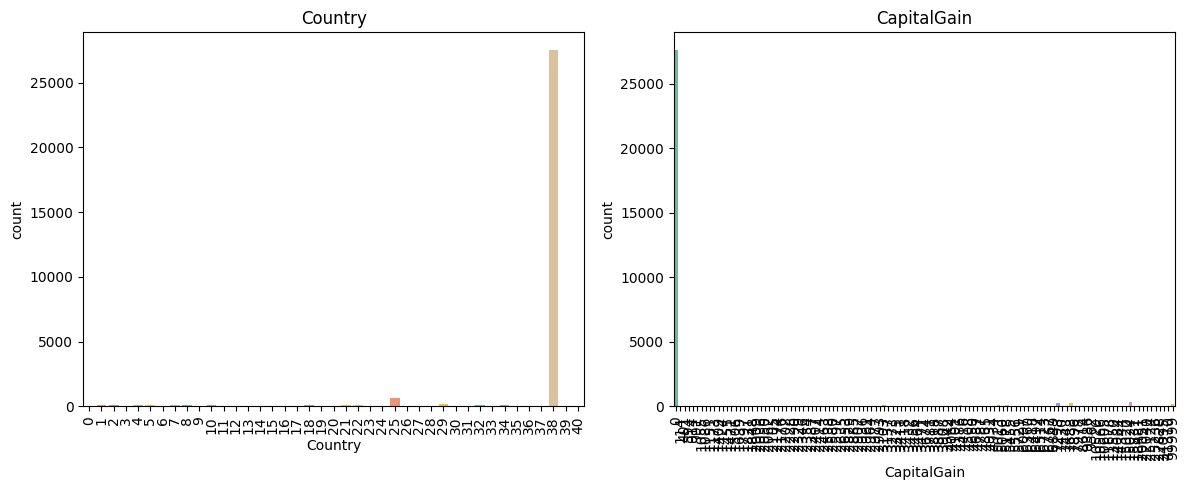

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Country', data=adult_data_train_copy, palette='Set2')
plt.title('Country')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x='CapitalGain', data=adult_data_train_copy, palette='Set2')
plt.title('CapitalGain')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

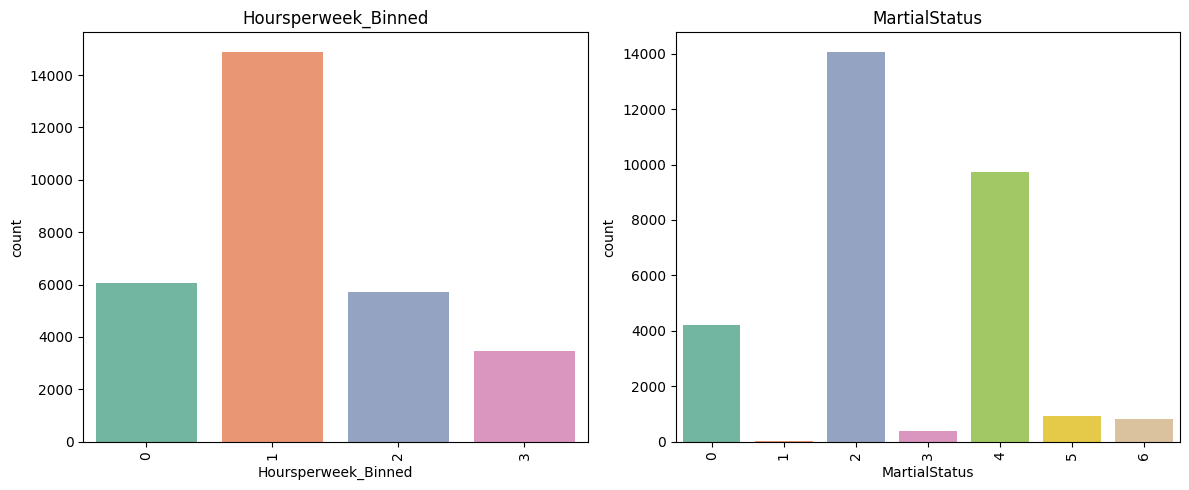

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Hoursperweek_Binned', data=adult_data_train_copy, palette='Set2')
plt.title('Hoursperweek_Binned')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x='MartialStatus', data=adult_data_train_copy, palette='Set2')
plt.title('MartialStatus')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [23]:
region = adult_data_train_copy.query('Hoursperweek_Binned==1')
region.groupby('Target').describe()

Workclass                                                fnlwgt  \
           count      mean       std  min  25%  50%  75%  max    count   
Target                                                                   
0        11669.0  2.105922  0.916326  0.0  2.0  2.0  2.0  6.0  11669.0   
1         3220.0  2.071739  1.088279  0.0  2.0  2.0  2.0  5.0   3220.0   

                       ... Age_Binned      Hoursperweek_Binned                 \
                 mean  ...        75%  max               count mean  std  min   
Target                 ...                                                      
0       193731.810866  ...        3.0  4.0             11669.0  1.0  0.0  1.0   
1       188977.250311  ...        4.0  4.0              3220.0  1.0  0.0  1.0   

                            
        25%  50%  75%  max  
Target                      
0       1.0  1.0  1.0  1.0  
1       1.0  1.0  1.0  1.0  

[2 rows x 104 columns]

In [24]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'Hoursperweek_Binned==1'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data) 

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 30162
Size of the new dataset: 38611
Time to train the model: 649.1454389095306 seconds

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.87 (+/- 0.01)
Recall: 0.84 (+/- 0.01)
F1 Score: 0.84 (+/- 0.01)
Log-loss: 0.29 (+/- 0.01)

Results on the validation set:
Accuracy: 0.93
Log-loss: 0.18

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     22654
           1       0.83      0.90      0.86      7508

    accuracy                           0.93     30162
   macro avg       0.90      0.92      0.91     30162
weighted avg       0.93      0.93      0.93     30162



In [25]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'Hoursperweek_Binned==1'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data) 

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 30162
Size of the new dataset: 35110
Time to train the model: 370.9657254219055 seconds

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.00)
Recall: 0.78 (+/- 0.01)
F1 Score: 0.80 (+/- 0.01)
Log-loss: 0.31 (+/- 0.01)

Results on the validation set:
Accuracy: 0.93
Log-loss: 0.20

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     22654
           1       0.85      0.87      0.86      7508

    accuracy                           0.93     30162
   macro avg       0.90      0.91      0.91     30162
weighted avg       0.93      0.93      0.93     30162



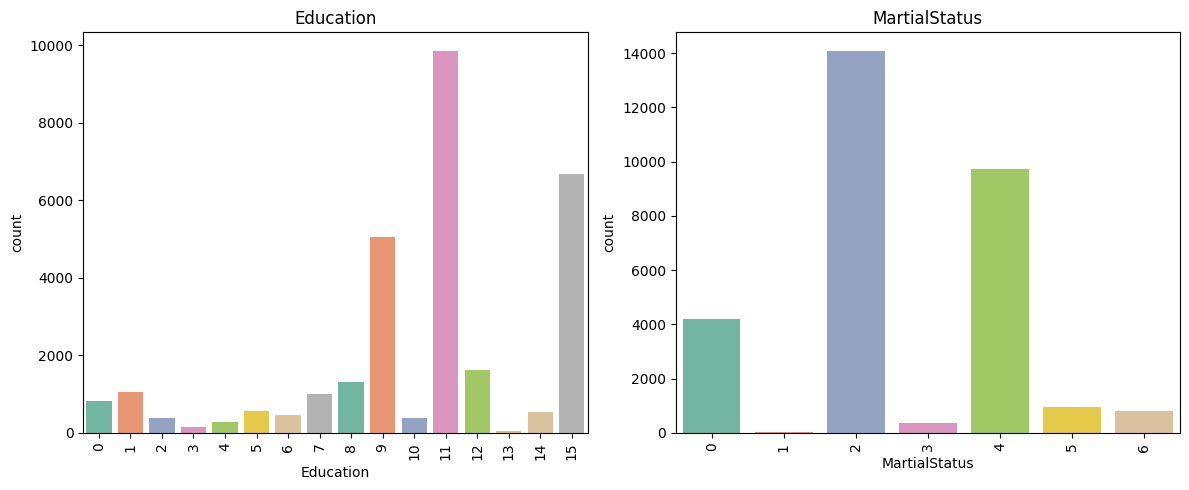

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Education', data=adult_data_train_copy, palette='Set2')
plt.title('Education')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x='MartialStatus', data=adult_data_train_copy, palette='Set2')
plt.title('MartialStatus')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [28]:
region = adult_data_train_copy.query('Education==14')
region.groupby('Target').describe()

Workclass                                              fnlwgt  \
           count      mean       std  min  25%  50%  75%  max  count   
Target                                                                 
0          136.0  2.529412  1.252796  0.0  2.0  2.0  4.0  5.0  136.0   
1          406.0  2.687192  1.185586  0.0  2.0  2.0  4.0  5.0  406.0   

                       ... Age_Binned      Hoursperweek_Binned            \
                 mean  ...        75%  max               count      mean   
Target                 ...                                                 
0       186103.691176  ...        4.0  4.0               136.0  1.404412   
1       185459.416256  ...        3.0  4.0               406.0  1.889163   

                                           
             std  min  25%  50%  75%  max  
Target                                     
0       1.098003  0.0  1.0  1.0  2.0  3.0  
1       0.988842  0.0  1.0  2.0  3.0  3.0  

[2 rows x 104 columns]

In [29]:
region = adult_data_train_copy.query('MartialStatus==4')
region.groupby('Target').describe()

Workclass                                               fnlwgt  \
           count      mean       std  min  25%  50%  75%  max   count   
Target                                                                  
0         9256.0  2.116141  0.824932  0.0  2.0  2.0  2.0  6.0  9256.0   
1          470.0  2.193617  1.056386  0.0  2.0  2.0  2.0  5.0   470.0   

                       ... Age_Binned      Hoursperweek_Binned            \
                 mean  ...        75%  max               count      mean   
Target                 ...                                                 
0       195561.045268  ...        1.0  4.0              9256.0  0.909464   
1       198494.042553  ...        3.0  4.0               470.0  1.731915   

                                           
             std  min  25%  50%  75%  max  
Target                                     
0       0.839086  0.0  0.0  1.0  1.0  3.0  
1       0.856707  0.0  1.0  2.0  2.0  3.0  

[2 rows x 104 columns]

In [30]:
region = adult_data_train_copy.query('MartialStatus==5')
region.groupby('Target').describe()

Workclass                                             fnlwgt  \
           count     mean       std  min  25%  50%  75%  max  count   
Target                                                                
0          873.0  2.15693  0.882748  0.0  2.0  2.0  2.0  5.0  873.0   
1           66.0  2.00000  0.928191  0.0  2.0  2.0  2.0  5.0   66.0   

                       ... Age_Binned      Hoursperweek_Binned            \
                 mean  ...        75%  max               count      mean   
Target                 ...                                                 
0       207213.994273  ...        3.0  4.0               873.0  0.997709   
1       210674.075758  ...        3.0  4.0                66.0  1.712121   

                                           
             std  min  25%  50%  75%  max  
Target                                     
0       0.785473  0.0  1.0  1.0  1.0  3.0  
1       0.855123  0.0  1.0  2.0  2.0  3.0  

[2 rows x 104 columns]

In [31]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'Education==14'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data) 

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 30162
Size of the new dataset: 30432
Time to train the model: 359.8828616142273 seconds

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.00)
Recall: 0.62 (+/- 0.01)
F1 Score: 0.69 (+/- 0.01)
Log-loss: 0.31 (+/- 0.00)

Results on the validation set:
Accuracy: 0.91
Log-loss: 0.22

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     22654
           1       0.88      0.74      0.80      7508

    accuracy                           0.91     30162
   macro avg       0.90      0.85      0.87     30162
weighted avg       0.91      0.91      0.91     30162



In [ ]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'MartialStatus==4'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data) 

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 30162
Size of the new dataset: 38948
Time to train the model: 604.1818115711212 seconds

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.87 (+/- 0.00)
Recall: 0.83 (+/- 0.01)
F1 Score: 0.85 (+/- 0.01)
Log-loss: 0.29 (+/- 0.01)

Results on the validation set:
Accuracy: 0.93
Log-loss: 0.18

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     22654
           1       0.86      0.87      0.86      7508

    accuracy                           0.93     30162
   macro avg       0.91      0.91      0.91     30162
weighted avg       0.93      0.93      0.93     30162



In [33]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'MartialStatus==5'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data) 

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 30162
Size of the new dataset: 30969
Time to train the model: 408.32780838012695 seconds

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.86 (+/- 0.01)
Recall: 0.66 (+/- 0.01)
F1 Score: 0.72 (+/- 0.01)
Log-loss: 0.31 (+/- 0.01)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.24

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     22654
           1       0.86      0.71      0.78      7508

    accuracy                           0.90     30162
   macro avg       0.89      0.84      0.86     30162
weighted avg       0.90      0.90      0.90     30162



In [37]:
from sklearn.metrics import make_scorer, log_loss, classification_report
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.over_sampling import SMOTE
import time
import numpy as np
import pandas as pd

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1',
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the regions
region_1 = 'MartialStatus==4'
region_2 = 'MartialStatus==5'

# Função para aplicar SMOTE em uma região
def apply_smote_to_region(X, y, region_query):
    X_region = X.query(region_query)
    y_region = y.loc[X_region.index]
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_region, y_region)
    return pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled)

# Aplica SMOTE nas duas regiões
X_region_1, y_region_1 = apply_smote_to_region(X_train, y_train, region_1)
X_region_2, y_region_2 = apply_smote_to_region(X_train, y_train, region_2)

# Remove as amostras originais dessas regiões
indices_to_drop = X_train.query(region_1).index.union(X_train.query(region_2).index)
X_remaining = X_train.drop(index=indices_to_drop)
y_remaining = y_train.drop(index=indices_to_drop)

# Combina as regiões com o restante dos dados
X_SMOTE_data = pd.concat([X_remaining, X_region_1, X_region_2], ignore_index=True)
y_SMOTE_data = pd.concat([y_remaining, y_region_1, y_region_2], ignore_index=True)

# Treina o modelo
start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Avaliação com cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

# Avaliação no conjunto de validação
rf_optimized.fit(X_SMOTE_data, y_SMOTE_data)
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Resultados
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")

print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))


Size of dataset: 30162
Size of the new dataset: 39755
Time to train the model: 704.4250907897949 seconds

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.88 (+/- 0.00)
Recall: 0.84 (+/- 0.01)
F1 Score: 0.85 (+/- 0.01)
Log-loss: 0.29 (+/- 0.00)

Results on the validation set:
Accuracy: 0.93
Log-loss: 0.21

Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     22654
           1       0.85      0.86      0.85      7508

    accuracy                           0.93     30162
   macro avg       0.90      0.90      0.90     30162
weighted avg       0.93      0.93      0.93     30162

